# notes
To increase accuracy, where possible, distance accross multiple points was averaged and divided

In [4]:
import numpy as np
import matplotlib.pyplot as plt


from uncertainties import ufloat
import uncertainties.unumpy as unp

from scipy.optimize import curve_fit
import scipy.odr as odr

from glob import glob

In [78]:
laserSpotHeight = [155, 157]
platformHeightFromGround = [108, 107]
containerHeight = [3.3, 3.6]

heights = [(h1 - (h2 + h3))/100 for h1, h2, h3 in zip(laserSpotHeight, platformHeightFromGround, containerHeight)]
print(f"Height measurements: {heights}")

H = ufloat(np.mean(heights), np.std(heights)) # meters
print(H)

L = ufloat(5.6, 0.05) # meters

lightWavelength = 633e-9 # m
waterDensity = 998.2 # kg m^-3
soapDensity = 1000 * 64.4/60

grazingAngle = unp.arctan2(H, L)

rootPath = "/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/"

Height measurements: [0.43700000000000006, 0.4640000000000001]
0.451+/-0.014


In [6]:
def LoadData(path):
    data = np.loadtxt(path, skiprows=1)

    frequencies = data[:,0]
    spacings = data[:,1]/1000 # change mm to m
    spacingUncertanties = data[:,2]/1000

    spacings = np.array([ufloat(spacing, uncertainty) for spacing, uncertainty in zip(spacings, spacingUncertanties)])

    return (frequencies, spacings)

In [7]:
def GetAngularFrequencies(frequencies):
    angularFrequencies = 2 * np.pi * frequencies
    return angularFrequencies

In [8]:
def GetDiffractionAngles(spacings):
    # Input in meters will give an output in degrees

    diffractionAngles = unp.arctan2(spacings, L)

    return diffractionAngles

In [9]:
def GetWaveNumbers(diffractionAngles):
    innerBracket = unp.sin(grazingAngle + diffractionAngles / 2) + unp.sin(grazingAngle - diffractionAngles / 2)

    waveNumbers = 2 * (np.pi / lightWavelength) * unp.sin(diffractionAngles / 2) * innerBracket

    return waveNumbers

In [10]:
def LinearFunc(p, x):
    m, c = p
    return m * x + c

def PerformODR(function, x, y, xErr):
    model = odr.Model(function)

    data = odr.Data(x, y, wd= 1/xErr)

    odrOutput = odr.ODR(data, model, beta0=[0.03, 0])

    return odrOutput.run()

In [73]:
def DetermineSurfaceTension(dataPath, density, plotTitle="", showPlot=False, verbose=False):
    
    # Load and process data
    frequencies, spacings = LoadData(dataPath)

    angularFrequencies = GetAngularFrequencies(frequencies)
    diffractionAngles = GetDiffractionAngles(spacings)

    waveNumbers = GetWaveNumbers(diffractionAngles)

    # Fitting and plotting
    xValues = unp.nominal_values(waveNumbers**3)
    xErr = unp.std_devs(waveNumbers**3)

    yValues = unp.nominal_values(density * angularFrequencies**2)
    yErr = unp.std_devs(density * angularFrequencies**2)

    regression = PerformODR(LinearFunc, xValues, yValues, xErr)

    if verbose: regression.pprint()

    if showPlot:
        fig, ax = plt.subplots(figsize=(5,5))

        ax.errorbar(xValues, yValues, xerr=xErr, fmt="o", color="indianred", capsize=3, linewidth=1, label="Data")

        xRange = np.linspace(np.min(xValues), np.max(xValues), 10)
        ax.plot(xValues, LinearFunc(regression.beta, xValues), color="mediumturquoise", lw=2, ls="dotted", label=f"ODR Fit, m={regression.beta[0]:.4f}, c={regression.beta[1]:.2f}")

        ax.set_xlabel("$k^3$ [m$^{-3}$]")
        ax.set_ylabel(r"$\omega^2 \,\rho$ [Hz$^2$ kg m$^{-3}$]")
        ax.legend()
        ax.set_title(plotTitle)

    return (regression.beta[0], regression.sd_beta[0])

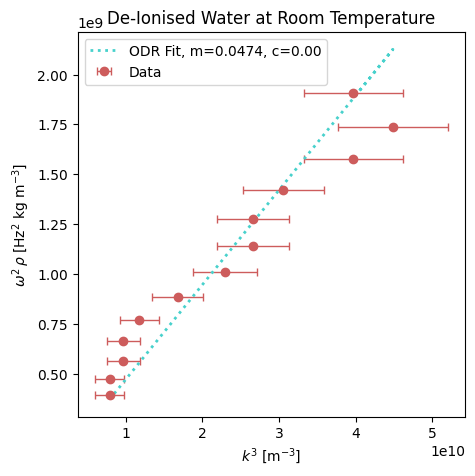

In [79]:
waterTension = DetermineSurfaceTension(rootPath + "/water.txt", waterDensity, plotTitle="De-Ionised Water at Room Temperature", showPlot=True)

# Soap

In [75]:
# Multiplot
def Multiplot(dataPath, densities, labels, colours, plotTitle, verbose=False):
    dataPaths = glob(dataPath)
    dataPaths.sort()
    print(dataPaths)

    dataList = []
    for dataPath in dataPaths:
        dataList.append(LoadData(dataPath))

    fig, ax = plt.subplots(figsize=(18,9))


    for data, density, colour, label in zip(dataList,densities, colours ,labels):
        # Load and process data
        frequencies, spacings = data

        angularFrequencies = GetAngularFrequencies(frequencies)
        diffractionAngles = GetDiffractionAngles(spacings)

        waveNumbers = GetWaveNumbers(diffractionAngles)

        # Fitting and plotting
        xValues = unp.nominal_values(waveNumbers**3)
        xErr = unp.std_devs(waveNumbers**3)

        yValues = unp.nominal_values(density * angularFrequencies**2)
        yErr = unp.std_devs(density * angularFrequencies**2)

        regression = PerformODR(LinearFunc, xValues, yValues, xErr)

        if verbose: regression.pprint()

        ax.errorbar(xValues, yValues, xerr=xErr, fmt="o", color=colour, capsize=3, linewidth=1, label=label + " - data")

        xRange = np.linspace(np.min(xValues), np.max(xValues), 10)
        ax.plot(xValues, LinearFunc(regression.beta, xValues), color=colour, lw=2, ls="dotted", label=label + f" - ODR Fit, $\sigma$={regression.beta[0]:.4f}")

    ax.set_xlabel("$k^3$ [m$^{-3}$]")
    ax.set_ylabel(r"$\omega^2 \,\rho$ [Hz$^2$ kg m$^{-3}$]")
    ax.legend()
    ax.set_title(plotTitle)    

['/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/soap_250_10.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/soap_250_20.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/soap_250_30.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/soap_250_50.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/soap_250_70.txt']


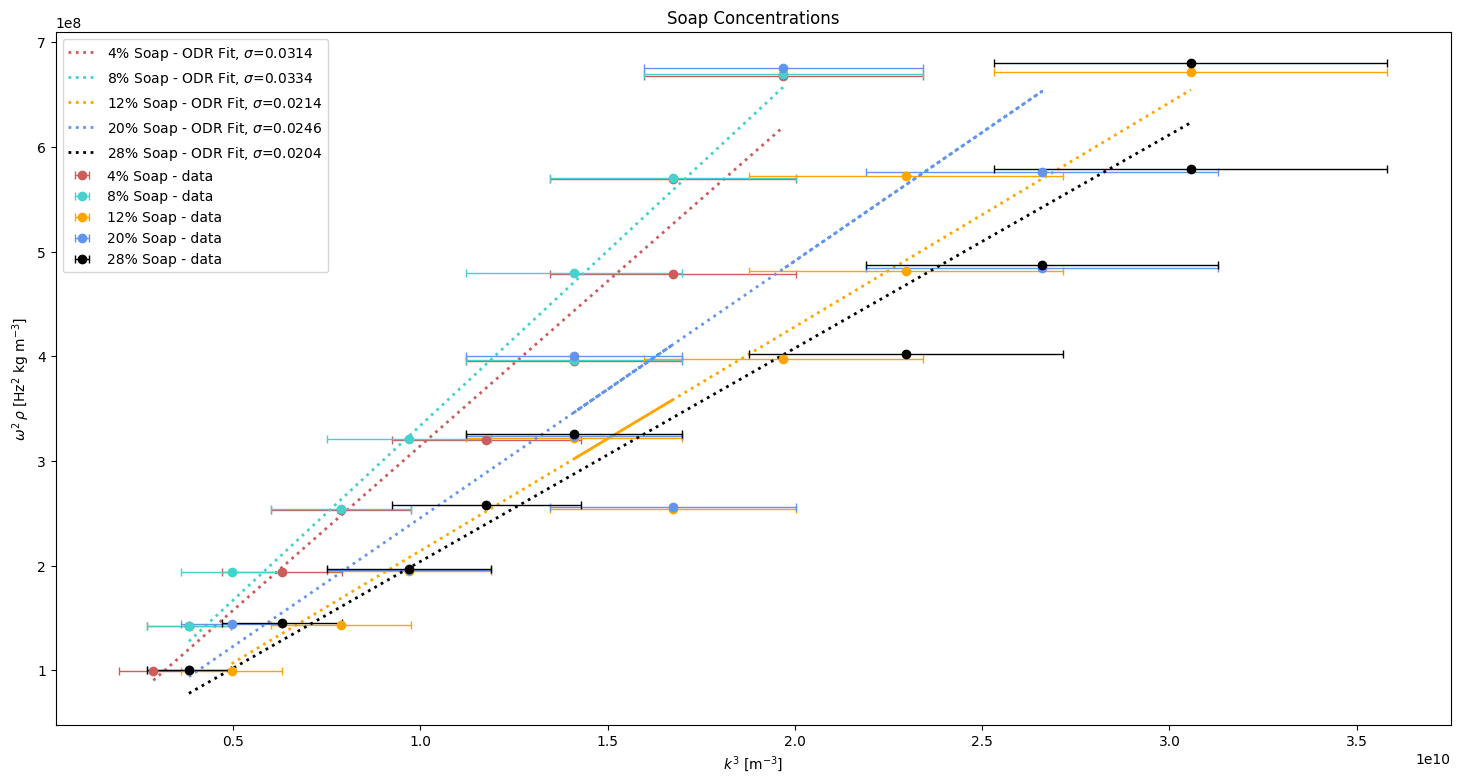

In [80]:
soapRatios = np.array([0.04, 0.08, 0.12, 0.2, 0.28])
soapDensities = soapRatios * soapDensity + ([1]*5 - soapRatios) * waterDensity

colours = ["indianred", "mediumturquoise", "orange", "cornflowerblue", "black"]

Multiplot(rootPath + "/soap_250_*.txt", soapDensities, [r"4% Soap", r"8% Soap", r"12% Soap", r"20% Soap", r"28% Soap"], colours, "Soap Concentrations")

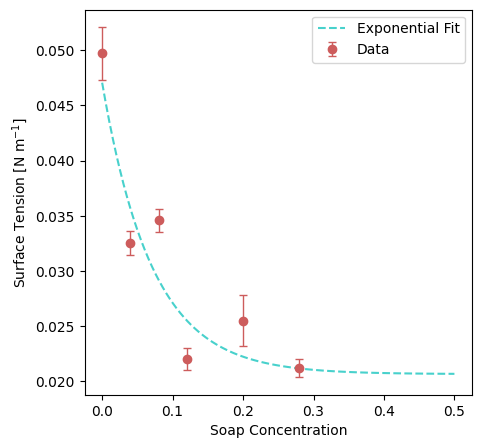

In [77]:
soapTension_250_10 = DetermineSurfaceTension(rootPath + "/soap_250_10.txt", soapDensities[0], plotTitle=r"0.04% soap at Room Temperature", showPlot=False)
soapTension_250_20 = DetermineSurfaceTension(rootPath + "/soap_250_20.txt", soapDensities[1], plotTitle=r"0.08% soap at Room Temperature", showPlot=False)
soapTension_250_30 = DetermineSurfaceTension(rootPath + "/soap_250_30.txt", soapDensities[2], plotTitle=r"0.12% soap at Room Temperature", showPlot=False)
soapTension_250_50 = DetermineSurfaceTension(rootPath + "/soap_250_50.txt", soapDensities[3], plotTitle=r"0.20% soap at Room Temperature", showPlot=False)
soapTension_250_70 = DetermineSurfaceTension(rootPath + "/soap_250_70.txt", soapDensities[4], plotTitle=r"0.28% soap at Room Temperature", showPlot=False)

soapRatios = np.array([0, 0.04, 0.08, 0.12, 0.2, 0.28])

soapTensions = np.array([waterTension, soapTension_250_10, soapTension_250_20, soapTension_250_30, soapTension_250_50, soapTension_250_70])

# FITTING
def ExpCurve(x, A, B, C):
    return A * np.exp(B * x) + C

def LinearCurve(x, m, c):
    return m * x + c

# Exponential fit
expPars, expCov = curve_fit(ExpCurve, soapRatios, soapTensions[:, 0], [0.05, -5, 0], sigma=soapTensions[:, 1])

# Dual linear fit
firstLinearPars, firstLinearCov = curve_fit(LinearCurve, soapRatios[0:4], soapTensions[:, 0][0:4], sigma=soapTensions[:, 1][0:4])
secondLinearPars, secondLinearCov = curve_fit(LinearCurve, soapRatios[3:], soapTensions[:, 0][3:], sigma=soapTensions[:, 1][3:])

# PLOTTING

fig, ax = plt.subplots(figsize=(5,5))

for ratio, tension in zip(soapRatios, soapTensions):
    if ratio == soapRatios[0]:
        label = "Data"
    else: label = ""

    ax.errorbar(ratio, tension[0], yerr=tension[1], fmt="o", color="indianred", capsize=3, linewidth=1, label=label)

xRange = np.linspace(0, 0.5, 100)
ax.plot(xRange, ExpCurve(xRange, expPars[0], expPars[1], expPars[2]), color="mediumturquoise", ls="--", label="Exponential Fit")
#ax.plot(xRange[0:int(len(xRange)/3)], LinearCurve(xRange[0:int(len(xRange)/3)], firstLinearPars[0], firstLinearPars[1]), color="coral", ls="--", label="Piecewise Linear Fit")
#ax.plot(xRange[int(len(xRange)/6):], LinearCurve(xRange[int(len(xRange)/6):], secondLinearPars[0], secondLinearPars[1]), color="coral", ls="--")


ax.set_xlabel("Soap Concentration")
ax.set_ylabel("Surface Tension [N m$^{-1}$]")
ax.legend()

# Salt

['/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/salt_250_05.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/salt_250_10.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/salt_250_15.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/salt_250_20.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/salt_250_25.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/salt_250_30.txt', '/home/daraghhollman/Main/ucd_4thYearLabs/surfaceTension/data/salt_250_40.txt']


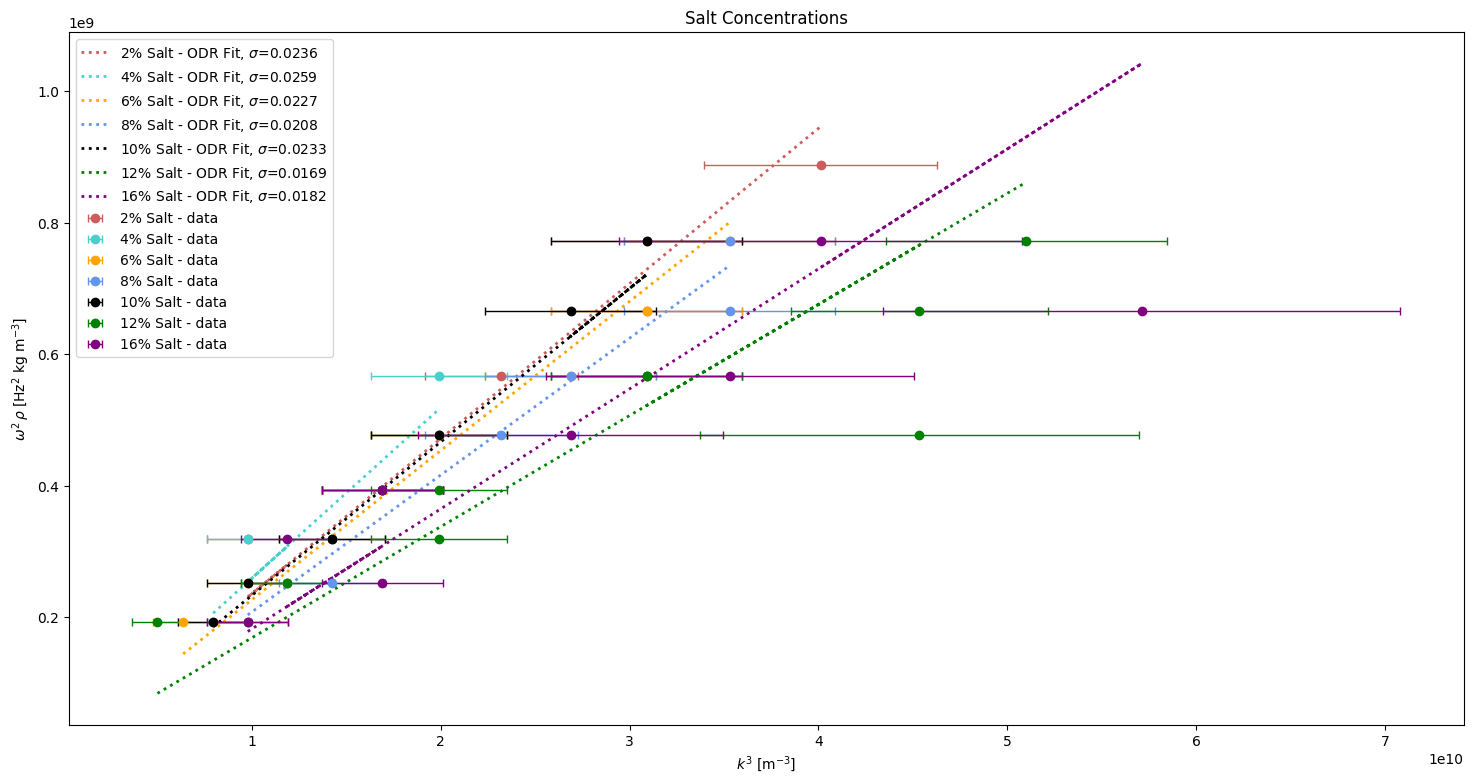

In [34]:
saltRatios = [waterDensity]*7

colours = ["indianred", "mediumturquoise", "orange", "cornflowerblue", "black", "green", "purple"]

Multiplot(rootPath + "/salt_250_*.txt", saltRatios, [r"2% Salt", r"4% Salt", r"6% Salt", r"8% Salt", r"10% Salt", r"12% Salt", r"16% Salt"], colours, "Salt Concentrations")

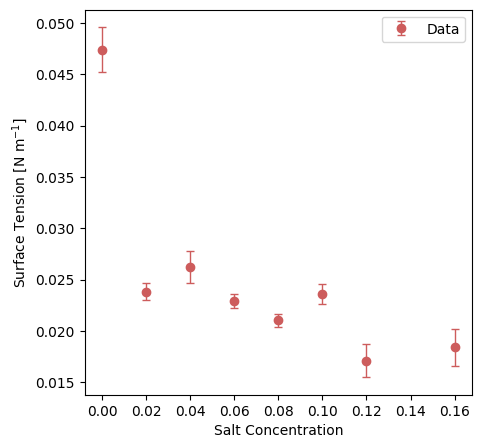

In [71]:
saltDensity = waterDensity

saltTension_250_05 = DetermineSurfaceTension(rootPath + "/salt_250_05.txt", saltDensity, showPlot=False)
saltTension_250_10 = DetermineSurfaceTension(rootPath + "/salt_250_10.txt", saltDensity, showPlot=False)
saltTension_250_15 = DetermineSurfaceTension(rootPath + "/salt_250_15.txt", saltDensity, showPlot=False)
saltTension_250_20 = DetermineSurfaceTension(rootPath + "/salt_250_20.txt", saltDensity, showPlot=False)
saltTension_250_25 = DetermineSurfaceTension(rootPath + "/salt_250_25.txt", saltDensity, showPlot=False)
saltTension_250_30 = DetermineSurfaceTension(rootPath + "/salt_250_30.txt", saltDensity, showPlot=False)
saltTension_250_40 = DetermineSurfaceTension(rootPath + "/salt_250_40.txt", saltDensity, showPlot=False)

saltTensions = np.array([waterTension, saltTension_250_05, saltTension_250_10, saltTension_250_15, saltTension_250_20, saltTension_250_25, saltTension_250_30, saltTension_250_40])

saltRatios = np.array([0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.16])

# PLOTTING

fig, ax = plt.subplots(figsize=(5,5))

for ratio, tension in zip(saltRatios, saltTensions):
    if ratio == soapRatios[0]:
        label = "Data"
    else: label = ""

    ax.errorbar(ratio, tension[0], yerr=tension[1], fmt="o", color="indianred", capsize=3, linewidth=1, label=label)

#xRange = np.linspace(0, 0.5, 100)
#ax.plot(xRange, ExpCurve(xRange, expPars[0], expPars[1], expPars[2]), color="mediumturquoise", ls="--", label="Exponential Fit")
#ax.plot(xRange[0:int(len(xRange)/3)], LinearCurve(xRange[0:int(len(xRange)/3)], firstLinearPars[0], firstLinearPars[1]), color="coral", ls="--", label="Piecewise Linear Fit")
#ax.plot(xRange[int(len(xRange)/6):], LinearCurve(xRange[int(len(xRange)/6):], secondLinearPars[0], secondLinearPars[1]), color="coral", ls="--")

ax.set_xlabel("Salt Concentration")
ax.set_ylabel("Surface Tension [N m$^{-1}$]")
ax.legend()